# Generación de señales ECG con GAN (LSTM)

> Objetivo: entrenar un modelo GAN con un generador basado en LSTM para sintetizar señales ECG de una clase específica (p. ej., NSR).

## Flujo del notebook
- Preparación del entorno y librerías
- Configuración (seed, dispositivo)
- Carga y exploración de datos
- Creación del DataLoader
- Definición de los modelos (Generator y Discriminator)
- Rutina de entrenamiento y monitoreo de pérdidas
- Guardado de modelos y métricas
- Notas y siguientes pasos

In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

In [3]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)
config.device

'cuda:0'

## Entorno y dispositivo

- Se fija la semilla para asegurar reproducibilidad.
- Se detecta automáticamente si hay GPU disponible.
- La celda siguiente imprime el estado de la GPU (nvidia-smi) para confirmar recursos.

In [4]:
!nvidia-smi

Thu Nov  6 16:02:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P5             18W /  300W |    1743MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Carga de datos

- Definimos la ruta al CSV con señales ECG preprocesadas.
- El archivo esperado es `ECG_DATASET/dataset_ekg_df.csv`.
- `label` contiene la etiqueta textual y `class` la codificación numérica.
- Las columnas de señal son todas excepto las dos últimas (`[:-2]`).

In [5]:
path = "./ECG_DATASET/dataset_ekg_df.csv"
config.csv_path = path

config.csv_path

'./ECG_DATASET/dataset_ekg_df.csv'

In [8]:
df = pd.read_csv(config.csv_path)

### Vista rápida y ejemplo de señal

- Mostramos una señal de la clase NSR para verificar formato y escala.
- El eje X representa muestras; el eje Y, amplitud normalizada.

Text(0.5, 0, 'muestras')

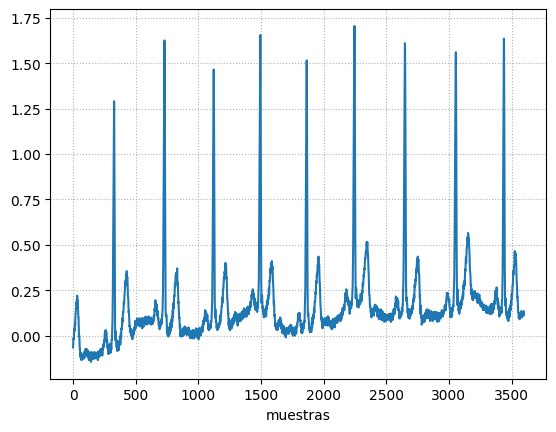

In [10]:
df[df["label"]=="NSR"].iloc[0,:-2].plot()
plt.grid(ls=":")
plt.xlabel("muestras")

## DataLoader personalizado

Esta sección construye un `Dataset` y un `DataLoader` para una clase específica:

- Filtra por `label` (ej. 'NSR').
- Convierte las señales a tensores `float32` con forma `(1, longitud)` para la red.
- Devuelve pares `(signal, target)` donde `target` es el índice numérico (`class`).
- `get_dataloader` vuelve a leer el CSV para permitir generar múltiples loaders de distintas clases si se quisiera.

In [11]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()
        # Pre-convertir los datos a arrays numpy para evitar warnings
        self.signals = self.df[self.data_columns].values.astype('float32')
        self.targets = self.df['class'].values.astype('int64')

    def __getitem__(self, idx):
        signal = torch.from_numpy(self.signals[idx]).unsqueeze(0)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader

In [12]:
dataloader = get_dataloader(label_name='NSR', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

3


(torch.Size([96, 1, 3600]), torch.Size([96]))

### Verificación del DataLoader

- Obtenemos un batch para comprobar las shapes de `x` y `y`.
- `x` debe ser `(B, 1, 3600)` y `y` `(B,)` si `signal_length=3600`.
- `len(dataloader)` indica cuántos batches hay por época.

## Modelado GAN (Generator + Discriminator)

En esta sección definimos las dos redes del GAN:

- Generator: MLP + LSTM bidireccional, proyección a la longitud de la señal y salida con `tanh`.
- Discriminator: pila de Conv1D + LSTM bidireccional, pooling global y capas densas con salida sigmoide.

La combinación busca capturar dependencias temporales de largo alcance y texturas locales de las señales ECG.

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, signal_length=3600):
        super(Generator, self).__init__()
        self.signal_length = signal_length
        self.latent_dim = latent_dim
        
        # Aumentar capacidad con más capas y batch normalization
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # LSTM más profundo
        self.lstm1 = nn.LSTM(
            input_size=1024,
            hidden_size=512,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        
        self.lstm2 = nn.LSTM(
            input_size=1024,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Capas finales con residual connection
        self.fc4 = nn.Linear(512, signal_length)
        self.fc5 = nn.Linear(signal_length, signal_length)
        
    def forward(self, z):
        # z shape: (batch, latent_dim)
        x = F.leaky_relu(self.bn1(self.fc1(z)), 0.2)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.fc3(x)), 0.2)
        
        # Reshape para LSTM
        x = x.unsqueeze(1)  # (batch, 1, 1024)
        
        # LSTM layers
        x, _ = self.lstm1(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x, _ = self.lstm2(x)
        
        # Flatten
        x = x.squeeze(1)  # (batch, 512)
        
        # Output layers con residual
        x1 = self.fc4(x)
        x2 = self.fc5(F.leaky_relu(x1, 0.2))
        x = x1 + x2  # Residual connection
        
        # Tanh para limitar el rango de salida
        return torch.tanh(x).unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self, signal_length=3600):
        super(Discriminator, self).__init__()
        self.signal_length = signal_length
        
        # Convoluciones 1D para extraer características
        self.conv1 = nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=7)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=15, stride=2, padding=7)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        
        # LSTM para capturar dependencias temporales
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        
        # Capas fully connected
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x shape: (batch, 1, signal_length)
        
        # Convoluciones
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        
        # Transpose para LSTM
        x = x.transpose(1, 2)  # (batch, seq_len, channels)
        
        # LSTM
        x, _ = self.lstm(x)
        
        # Global average pooling
        x = torch.mean(x, dim=1)  # (batch, 512)
        
        # Fully connected
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        
        return x

### Detalles de la arquitectura

- Regularización: BatchNorm y Dropout (aplicado en capas intermedias).
- Conexión residual en el generador para estabilizar y mejorar gradientes.
- Salida del generador acotada a [-1, 1] mediante `tanh`.
- `signal_length` parametriza la longitud de salida (3600 por defecto).

In [14]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label,
        latent_dim=100,
        signal_length=3600
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        # Optimizadores con betas mejorados para GANs
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
        
        # Schedulers para learning rate
        self.schedulerD = torch.optim.lr_scheduler.StepLR(self.optimizerD, step_size=500, gamma=0.95)
        self.schedulerG = torch.optim.lr_scheduler.StepLR(self.optimizerG, step_size=500, gamma=0.95)
        
        # Criterios
        self.criterion = nn.BCELoss()
        self.mse_criterion = nn.MSELoss()
        
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.signal_length = signal_length
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(label_name=label, batch_size=self.batch_size)
        
        self.fixed_noise = torch.randn(self.batch_size, self.latent_dim, device=self.device)
        
        self.g_errors = []
        self.d_errors = []
        
        # Etiquetas suaves para estabilizar entrenamiento
        self.real_label = 0.9
        self.fake_label = 0.1
        
    def _one_epoch(self):
        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0
        
        for i, data in enumerate(self.dataloader):
            batch_size = data[0].size(0)
            real_data = data[0].to(self.device)
            
            ##### Update Discriminator #####
            self.netD.zero_grad()
            
            # Etiquetas con label smoothing
            real_labels = torch.full((batch_size,), self.real_label, 
                                    dtype=torch.float, device=self.device)
            fake_labels = torch.full((batch_size,), self.fake_label, 
                                    dtype=torch.float, device=self.device)
            
            # Train with real
            output_real = self.netD(real_data).view(-1)
            errD_real = self.criterion(output_real, real_labels)
            
            # Train with fake
            noise = torch.randn(batch_size, self.latent_dim, device=self.device)
            fake = self.netG(noise)
            output_fake = self.netD(fake.detach()).view(-1)
            errD_fake = self.criterion(output_fake, fake_labels)
            
            # Combine losses
            errD = (errD_real + errD_fake) / 2
            errD.backward()
            
            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(self.netD.parameters(), max_norm=1.0)
            self.optimizerD.step()
            
            ##### Update Generator (entrenar 2 veces por cada vez del discriminador) #####
            for _ in range(2):
                self.netG.zero_grad()
                
                noise = torch.randn(batch_size, self.latent_dim, device=self.device)
                fake = self.netG(noise)
                output = self.netD(fake).view(-1)
                
                # Queremos que el discriminador piense que son reales
                real_labels_g = torch.full((batch_size,), 1.0, 
                                          dtype=torch.float, device=self.device)
                
                # Loss del GAN
                errG_gan = self.criterion(output, real_labels_g)
                
                # Feature matching loss (opcional pero útil)
                # Calcular estadísticas de las señales reales vs fake
                real_mean = real_data.mean(dim=2, keepdim=True)
                real_std = real_data.std(dim=2, keepdim=True)
                fake_mean = fake.mean(dim=2, keepdim=True)
                fake_std = fake.std(dim=2, keepdim=True)
                
                feature_loss = self.mse_criterion(fake_mean, real_mean) + \
                              self.mse_criterion(fake_std, real_std)
                
                # Combinar losses
                errG = errG_gan + 0.1 * feature_loss
                errG.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.netG.parameters(), max_norm=1.0)
                self.optimizerG.step()
            
            epoch_d_loss += errD.item()
            epoch_g_loss += errG.item()
            num_batches += 1
        
        # Update learning rates
        self.schedulerD.step()
        self.schedulerG.step()
        
        return epoch_d_loss / num_batches, epoch_g_loss / num_batches
        
    def run(self):
        print(f"Iniciando entrenamiento en {self.device}")
        print(f"Signal length: {self.signal_length}")
        print(f"Latent dim: {self.latent_dim}")
        print(f"Batch size: {self.batch_size}")
        print(f"Número de batches: {len(self.dataloader)}")
        print("-" * 60)
        
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            
            if epoch % 50 == 0:
                lr_d = self.optimizerD.param_groups[0]['lr']
                lr_g = self.optimizerG.param_groups[0]['lr']
                print(f"Epoch: {epoch:4d} | Loss_D: {errD_:.4f} | Loss_G: {errG_:.4f} | "
                      f"LR_D: {lr_d:.6f} | LR_G: {lr_g:.6f} | Time: {time.strftime('%H:%M:%S')}")
   
            if epoch % 200 == 0:
                self.netG.eval()
                with torch.no_grad():
                    fake = self.netG(self.fixed_noise)
                    fake_np = fake.detach().cpu().squeeze(1).numpy()
                    
                    # Graficar 5 señales generadas
                    plt.figure(figsize=(15, 8))
                    
                    plt.subplot(2, 1, 1)
                    plt.plot(fake_np[:5].T, alpha=0.7)
                    plt.title(f'Señales generadas - Época {epoch}')
                    plt.xlabel('Muestras')
                    plt.ylabel('Amplitud')
                    plt.grid(ls=":", alpha=0.5)
                    plt.legend([f'Señal {i+1}' for i in range(5)])
                    
                    # Graficar curvas de pérdida
                    plt.subplot(2, 1, 2)
                    plt.plot(self.d_errors, label='Discriminator Loss', alpha=0.7)
                    plt.plot(self.g_errors, label='Generator Loss', alpha=0.7)
                    plt.xlabel('Época')
                    plt.ylabel('Loss')
                    plt.title('Curvas de entrenamiento')
                    plt.legend()
                    plt.grid(ls=":", alpha=0.5)
                    
                    plt.tight_layout()
                    plt.show()
                    
                self.netG.train()
            
        # Crear carpeta si no existe
        os.makedirs("../resultados", exist_ok=True)
        
        # Guardar modelos
        torch.save(self.netG.state_dict(), "../resultados/generator2.pth")
        torch.save(self.netD.state_dict(), "../resultados/discriminator2.pth")
        
        # Guardar losses
        np.save("../resultados/g_losse2.npy", np.array(self.g_errors))
        np.save("../resultados/d_losses2.npy", np.array(self.d_errors))
        
        print("Modelos y losses guardados exitosamente!")

## Inicialización y lanzamiento del entrenamiento

- Instanciamos `Generator` y `Discriminator` con `signal_length` deseado.
- Mostramos parámetros totales para tener referencia de complejidad.
- Creamos `Trainer` y ejecutamos `run()`.

### Configuración y ejecución

- Ajusta `batch_size`, `num_epochs`, `label`, `latent_dim` y `signal_length` según los recursos disponibles.
- La ejecución puede tardar; usar GPU acelera notablemente el entrenamiento.
- Se imprimen estadísticas periódicas (LR, pérdidas, hora).

## Entrenamiento: pérdidas, trucos y registro

- Pérdidas: BCE para GAN; se añade feature matching (MSE sobre media y desviación) con peso 0.1.
- Trucos de estabilidad: label smoothing (reales=0.9, falsas=0.1), 2 pasos de G por 1 de D, gradient clipping y schedulers.
- Logging: cada 200 épocas se visualizan muestras generadas y curvas de pérdida.
- Persistencia: se guardan pesos y arrays de pérdidas en `../resultados`.

Generator parameters: 30,721,568
Discriminator parameters: 2,686,593
Iniciando entrenamiento en cuda:0
Signal length: 3600
Latent dim: 100
Batch size: 64
Número de batches: 5
------------------------------------------------------------
Epoch:    0 | Loss_D: 0.6922 | Loss_G: 0.7053 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:04:51


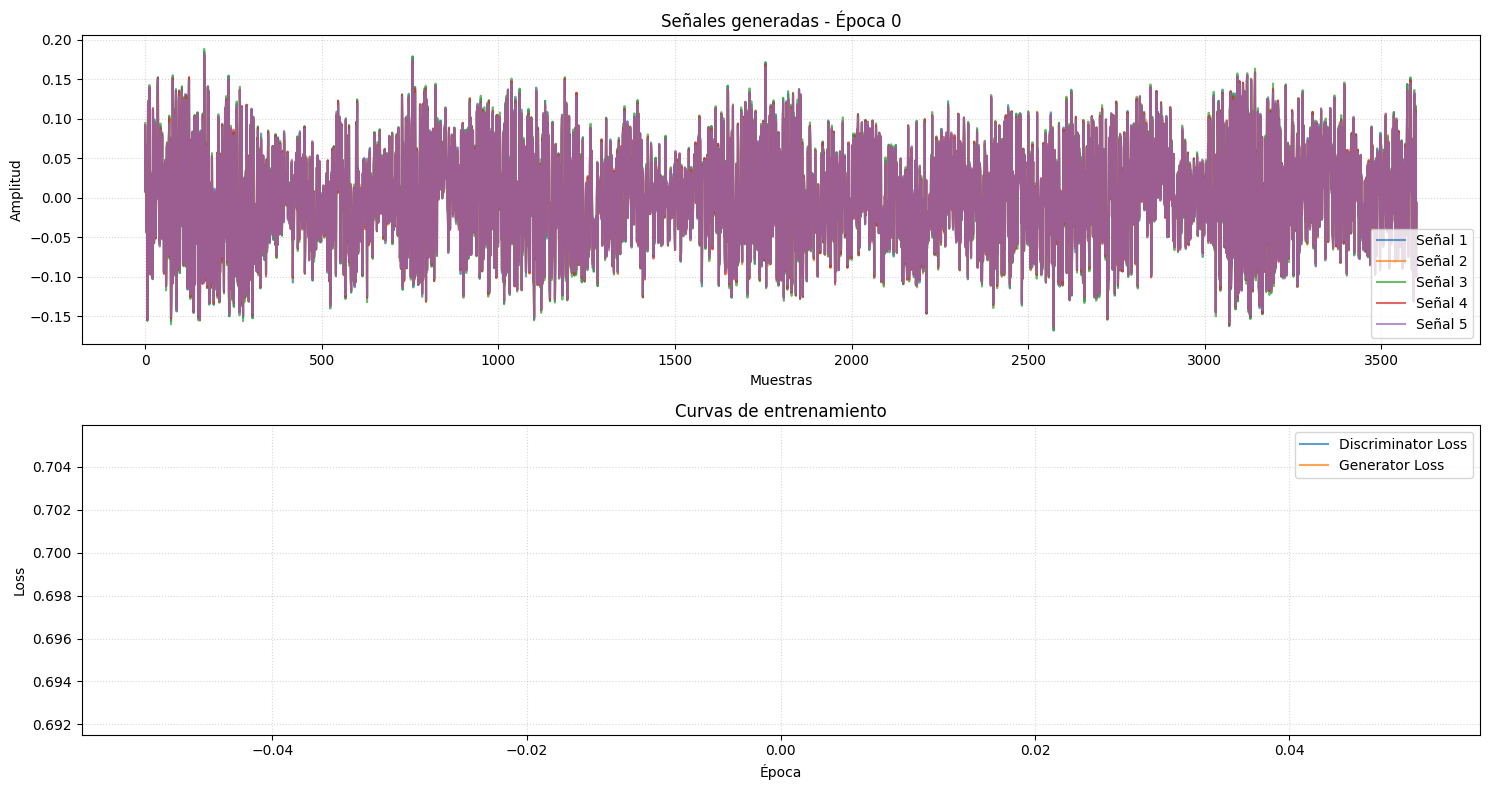

Epoch:   50 | Loss_D: 0.3294 | Loss_G: 2.3568 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:05:28
Epoch:  100 | Loss_D: 0.3323 | Loss_G: 2.3008 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:06:06
Epoch:  150 | Loss_D: 0.4746 | Loss_G: 2.3523 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:06:44
Epoch:  200 | Loss_D: 0.3672 | Loss_G: 2.2422 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:07:22


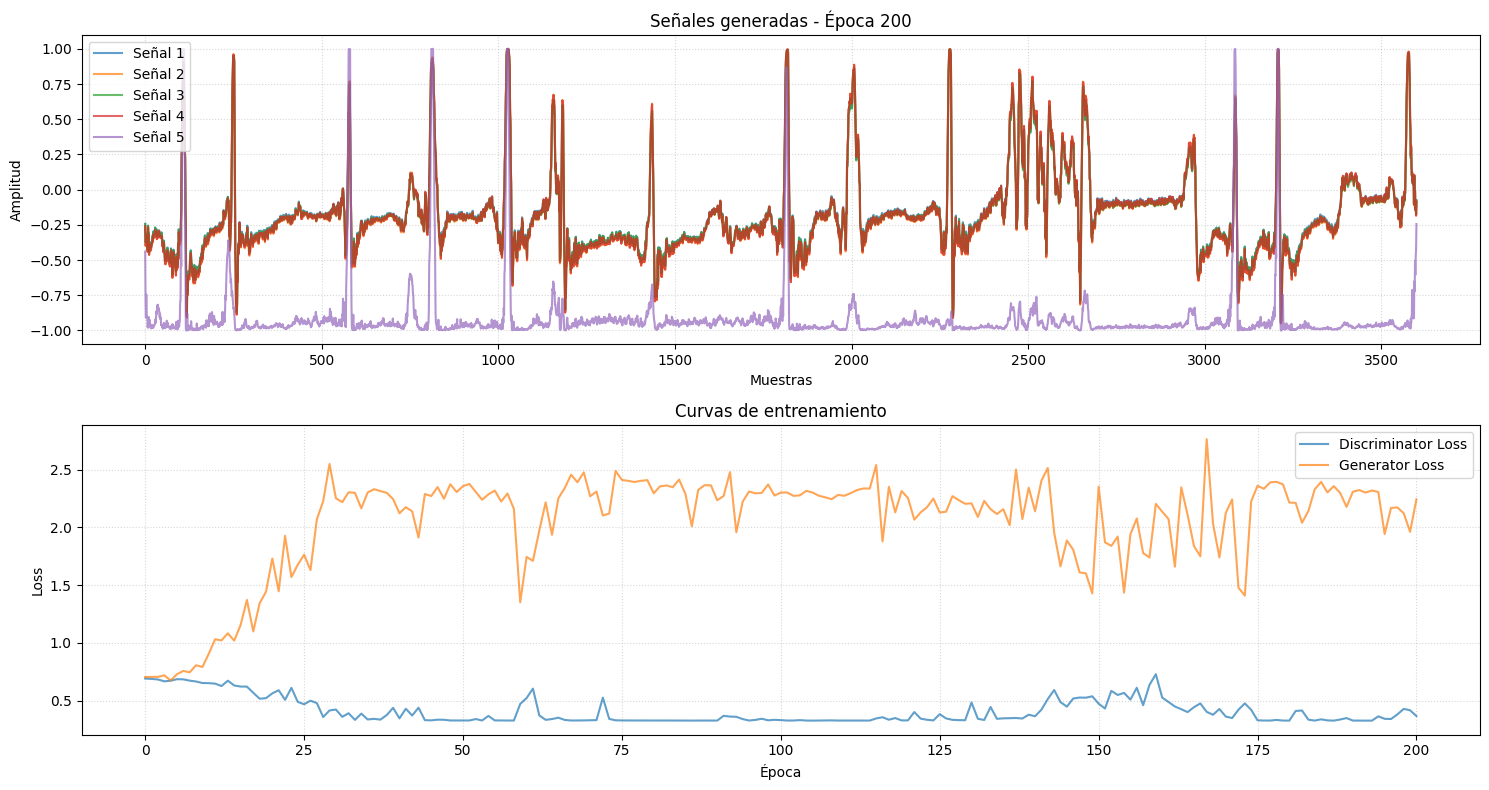

Epoch:  250 | Loss_D: 0.3478 | Loss_G: 2.1095 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:08:00
Epoch:  300 | Loss_D: 0.5523 | Loss_G: 1.4394 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:08:38
Epoch:  350 | Loss_D: 0.3274 | Loss_G: 2.2556 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:09:16
Epoch:  400 | Loss_D: 0.3277 | Loss_G: 2.3622 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:09:55


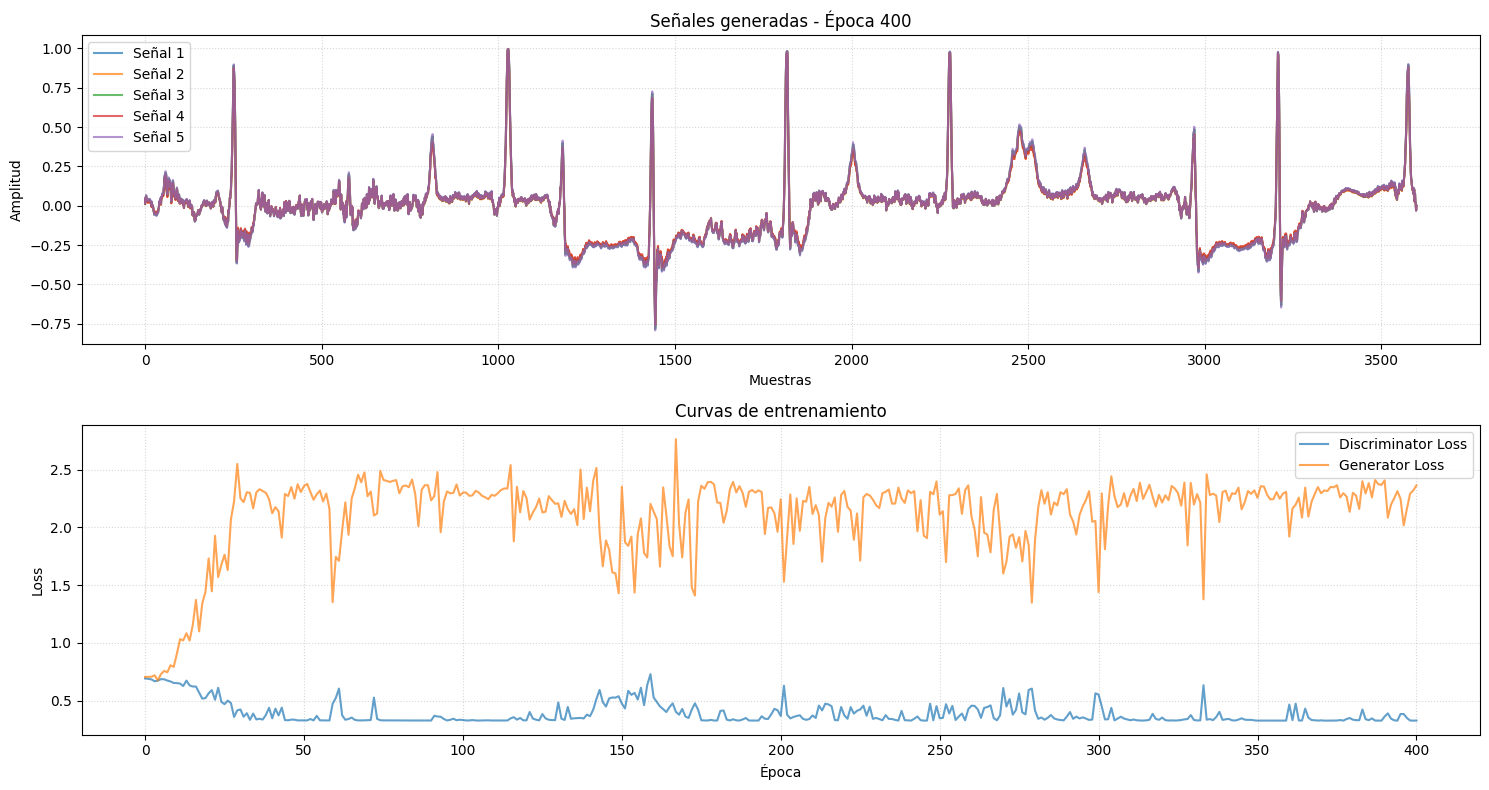

Epoch:  450 | Loss_D: 0.3276 | Loss_G: 2.3494 | LR_D: 0.000100 | LR_G: 0.000100 | Time: 16:10:33
Epoch:  500 | Loss_D: 0.3633 | Loss_G: 2.2285 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:11:11
Epoch:  550 | Loss_D: 0.3277 | Loss_G: 2.3563 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:11:49
Epoch:  600 | Loss_D: 0.3279 | Loss_G: 2.3622 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:12:28


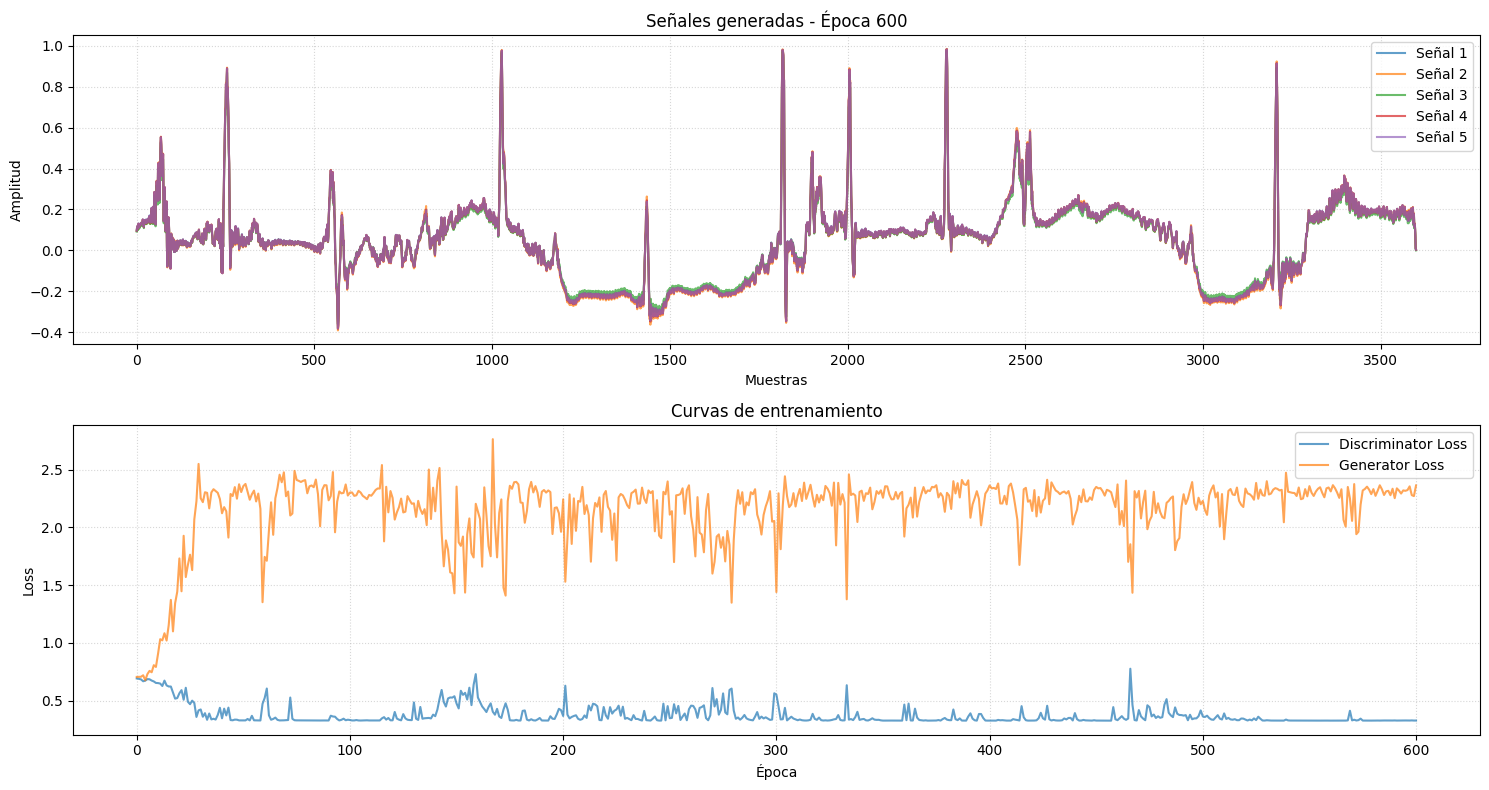

Epoch:  650 | Loss_D: 0.3278 | Loss_G: 2.3155 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:13:06
Epoch:  700 | Loss_D: 0.3378 | Loss_G: 2.0507 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:13:44
Epoch:  750 | Loss_D: 0.3275 | Loss_G: 2.1851 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:14:23
Epoch:  800 | Loss_D: 0.3281 | Loss_G: 2.2985 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:15:01


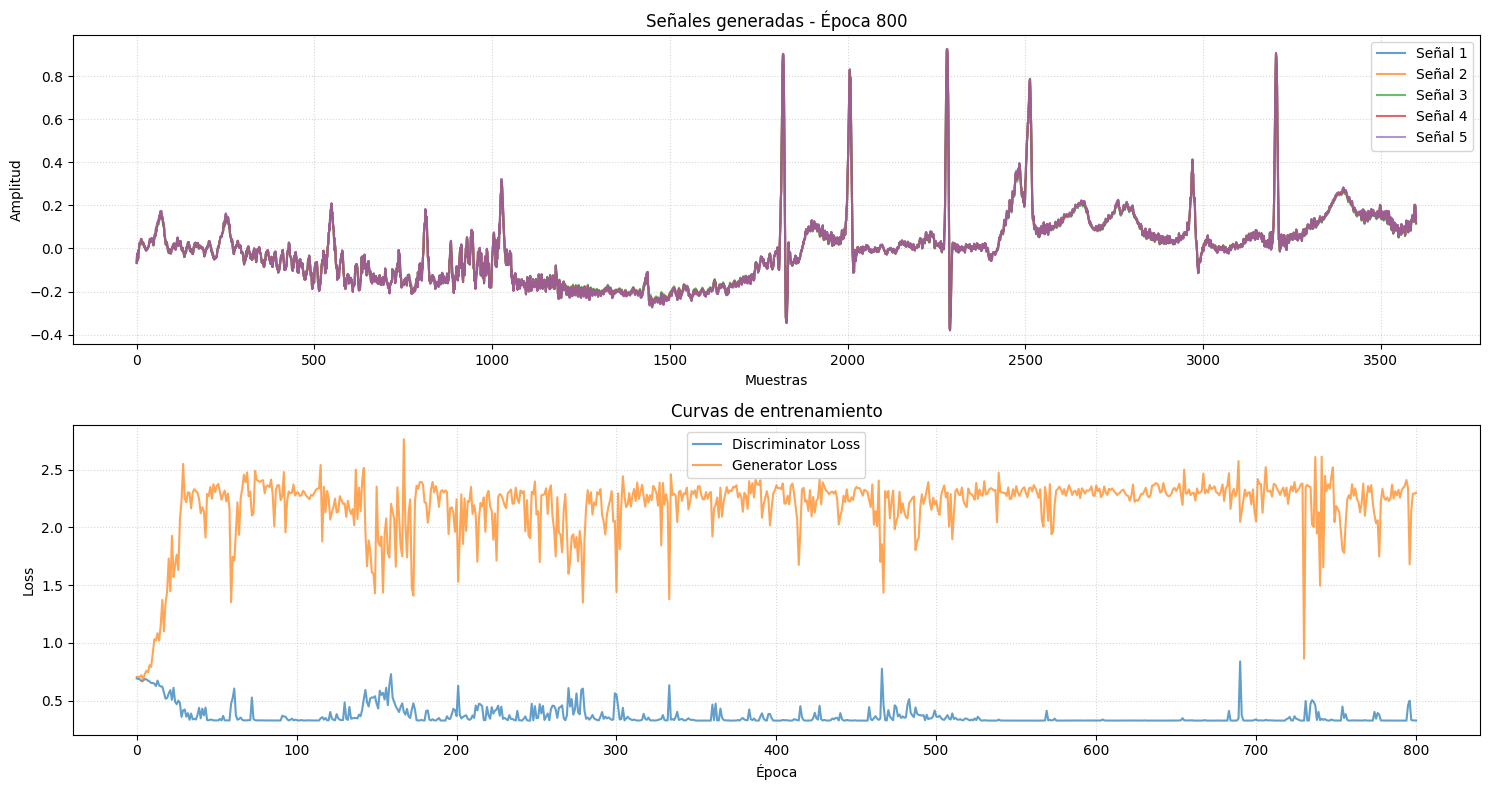

Epoch:  850 | Loss_D: 0.3273 | Loss_G: 2.3364 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:15:39
Epoch:  900 | Loss_D: 0.3269 | Loss_G: 2.3179 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:16:18
Epoch:  950 | Loss_D: 0.3319 | Loss_G: 2.0554 | LR_D: 0.000095 | LR_G: 0.000095 | Time: 16:16:56
Epoch: 1000 | Loss_D: 0.3272 | Loss_G: 2.2770 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:17:34


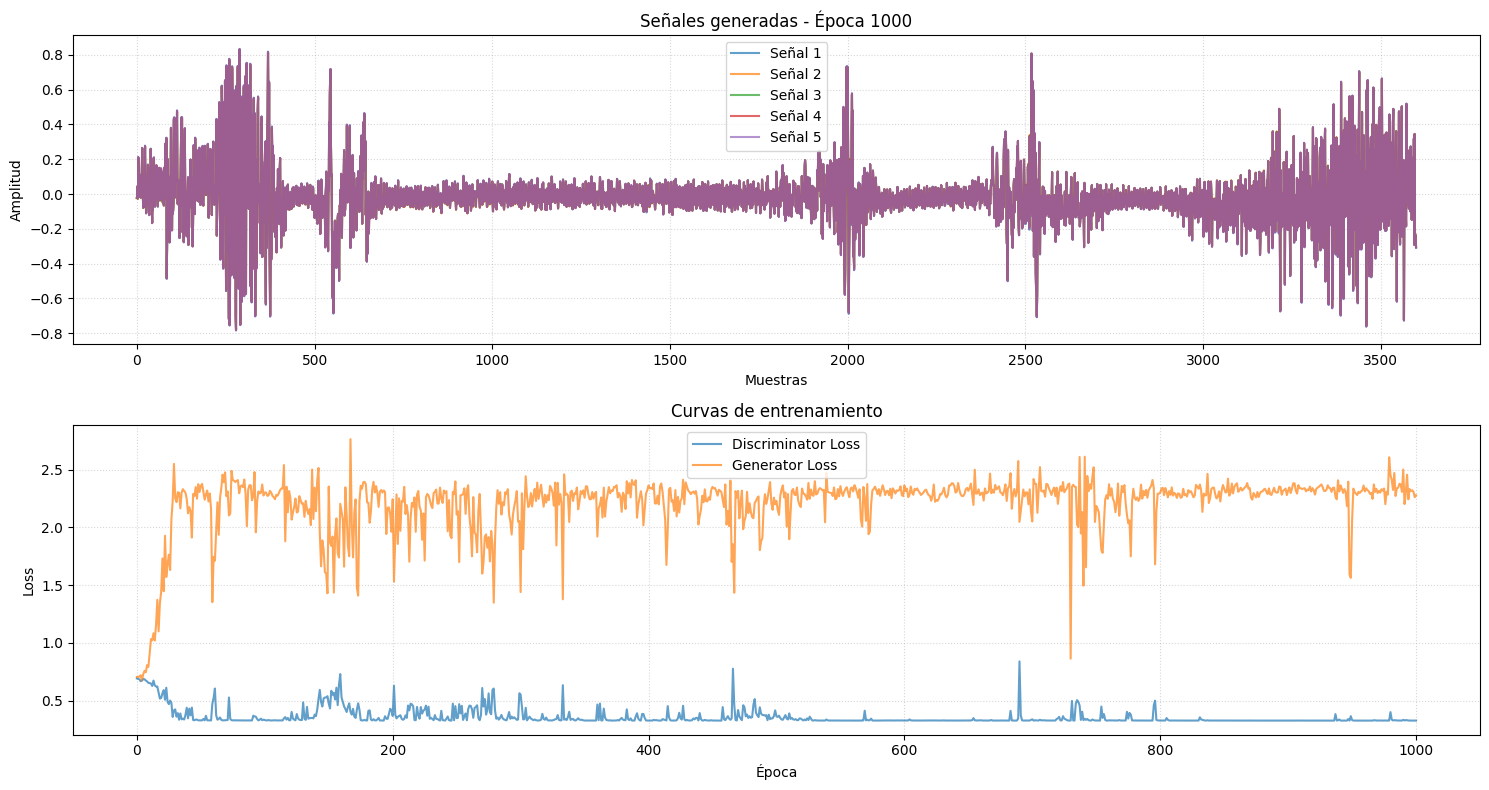

Epoch: 1050 | Loss_D: 0.3321 | Loss_G: 2.3245 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:18:12
Epoch: 1100 | Loss_D: 0.3268 | Loss_G: 2.3249 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:18:51
Epoch: 1150 | Loss_D: 0.3266 | Loss_G: 2.3455 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:19:29
Epoch: 1200 | Loss_D: 0.3268 | Loss_G: 2.3754 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:20:07


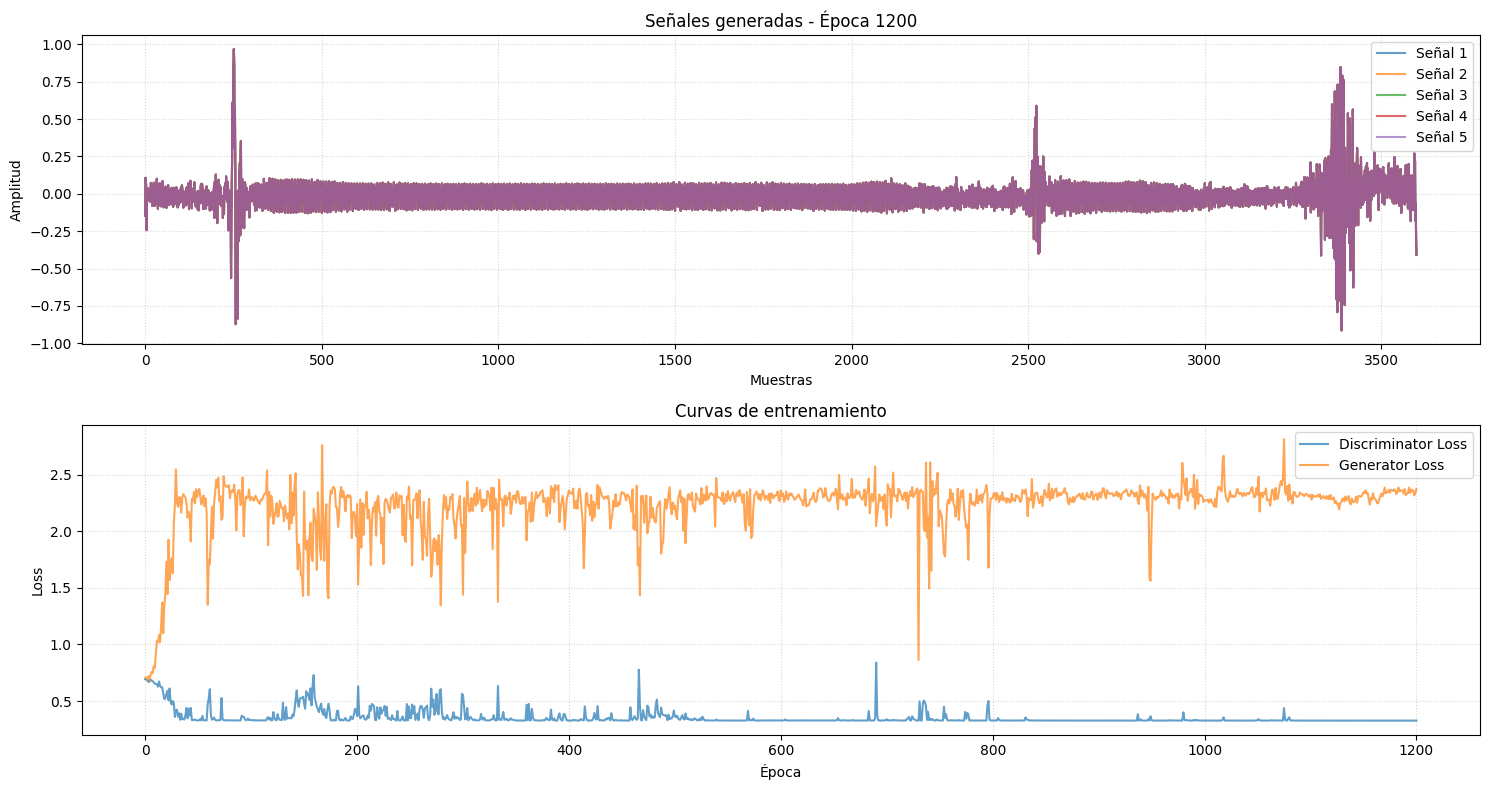

Epoch: 1250 | Loss_D: 0.3264 | Loss_G: 2.3665 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:20:46
Epoch: 1300 | Loss_D: 0.3264 | Loss_G: 2.3399 | LR_D: 0.000090 | LR_G: 0.000090 | Time: 16:21:24


In [ ]:
g = Generator(latent_dim=100, signal_length=3600)
d = Discriminator(signal_length=3600)

print(f"Generator parameters: {sum(p.numel() for p in g.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in d.parameters()):,}")

trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=64,  # Reducir batch size puede ayudar
    num_epochs=5000,
    label='NSR',
    latent_dim=100,
    signal_length=3600
)
trainer.run()